# P.1. PCA-Based Butterfly Trading

## 1. Project Statement

Construct a 2s5s10s Treasury butterfly trade that is neutral to the first two principal components of yield curve movements (level and slope), isolating exposure to curvature. Design and backtest a mean-reversion trading strategy on this curvature factor, then analyze the gap between yield-space returns and actual bond-level implementation.

## 2. Context

### Why Practitioners Care

Rates desks decompose yield curve movements into **factors**—typically level, slope, and curvature—to isolate and trade specific risks. A butterfly trade (long the wings, short the belly) is designed to profit from curvature movements while hedging out parallel shifts and steepening/flattening.

The challenge is constructing weights that actually neutralize unwanted exposures. A naive duration-matched butterfly still has slope exposure. PCA provides a systematic way to determine weights that neutralize both level (PC1) and slope (PC2), leaving pure exposure to curvature (PC3).

### Key Concepts

**PCA on yield changes (not levels):** Running PCA on daily yield *changes* is the standard approach for risk management. This differs from running PCA on yield *levels*, which captures the average shape of the curve rather than its dynamics.

**Factor-neutral positioning:** Given PCA loadings $L_1$ (for PC1) and $L_2$ (for PC2), we seek weights $w = (w_{2Y}, w_{5Y}, w_{10Y})$ such that:
- $w \cdot L_1 = 0$ (PC1 neutral)
- $w \cdot L_2 = 0$ (PC2 neutral)
- $w_{5Y} = -1$ (normalization: short the belly)

This is a 2×2 linear system that uniquely determines the wing weights.

**Mean-reversion in curvature:** Unlike level and slope, which can trend persistently, curvature tends to mean-revert. This creates potential for a trading strategy: go long curvature when it's cheap (below average), short when it's rich (above average).

**Implementation gap:** Trading a "yield index" is academic—real trades involve bonds. The P&L from actual bonds will differ from yield-space returns due to:
- Duration is a first-order approximation; convexity matters for larger moves
- Duration changes daily as yields move
- Bonds have coupons and carry
- Discrete rebalancing vs. continuous yield-space assumption

## 3. Resources

### Course Materials

| Material | Relevance |
|----------|----------|
| **D.2.1 Interest Rate Risk** | PCA on yield curves, level/slope/curvature interpretation, duration as sensitivity |
| **E.2.3 The Steepener Trade** | Duration-neutral trade construction, daily P&L with rebalancing, coupon handling |
| **D.2.2 Convexity** | Second-order effects, why duration-based hedges aren't perfect |

### External Reading

- [CME: Understanding Treasury Futures](https://www.cmegroup.com/education/courses/introduction-to-treasuries.html) — Institutional context for curve trades
- [NY Fed: The Yield Curve as a Leading Indicator](https://www.newyorkfed.org/research/capital_markets/ycfaq.html) — Economic interpretation of curve shape
- [FRED: Treasury Constant Maturity Rates](https://fred.stlouisfed.org/categories/115) — Public data source documentation

### Data Files

| File | Description | Frequency | Date Range |
|------|-------------|-----------|------------|
| `gsw_yields.xlsx` | GSW zero-coupon yields (30 maturities) | Daily | 1961–2025 |
| `treasury_panel_pca.xlsx` | Comprehensive Treasury panel (notes/bonds, TTM 1-12y) | Daily | 2022–2025 |

**GSW yields** provide clean zero-coupon rates for factor discovery (Questions 1-4).

**Treasury panel** provides actual bond data for implementation analysis (Question 5). The panel includes ~205 bonds per day with columns:
- `caldt`, `kytreasno`, `cusip`, `type` — identification
- `issue_date`, `maturity_date`, `ttm`, `age_days` — timing (use `age_days` to identify on-the-run bonds)
- `coupon`, `ytm`, `price`, `accrued_int`, `dirty_price`, `duration` — pricing

You will design your own bond selection and roll schedule for the implementation backtest.

## 4. Data Preview

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
# Load GSW yields
gsw = pd.read_excel('data/gsw_yields.xlsx', index_col=0, parse_dates=True)

# Select key maturities for the butterfly (columns are numeric: 1, 2, 3, ..., 30)
maturities = [2, 5, 10]
yields = gsw[maturities].dropna()
yields.columns = ['2Y', '5Y', '10Y']

# Focus on recent period (2015-2025)
yields = yields.loc['2015':]

print(f"Date range: {yields.index[0].date()} to {yields.index[-1].date()}")
print(f"Observations: {len(yields)}")
yields.tail()

Date range: 2015-01-02 to 2025-12-26
Observations: 2747


,2Y,5Y,10Y
Date,,,
2025-12-19,3.4741,3.6742,4.2367
2025-12-22,3.4956,3.6938,4.2475
2025-12-23,3.5287,3.7140,4.2410
2025-12-24,3.5278,3.7004,4.2158
2025-12-26,3.4816,3.6707,4.2193


In [3]:
# Compute yield changes
yield_changes = yields.diff().dropna()

# Run PCA on standardized changes
scaler = StandardScaler()
changes_scaled = scaler.fit_transform(yield_changes)

pca = PCA(n_components=3)
pca.fit(changes_scaled)

# Display loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=['2Y', '5Y', '10Y'],
    columns=['PC1', 'PC2', 'PC3']
)

print("Variance explained:", pca.explained_variance_ratio_.round(3))
print("\nFactor loadings:")
print(loadings.round(3))

Variance explained: [0.911 0.081 0.008]

Factor loadings:
       PC1    PC2    PC3
2Y   0.564  0.725 -0.395
5Y   0.600 -0.031  0.799
10Y  0.568 -0.688 -0.452


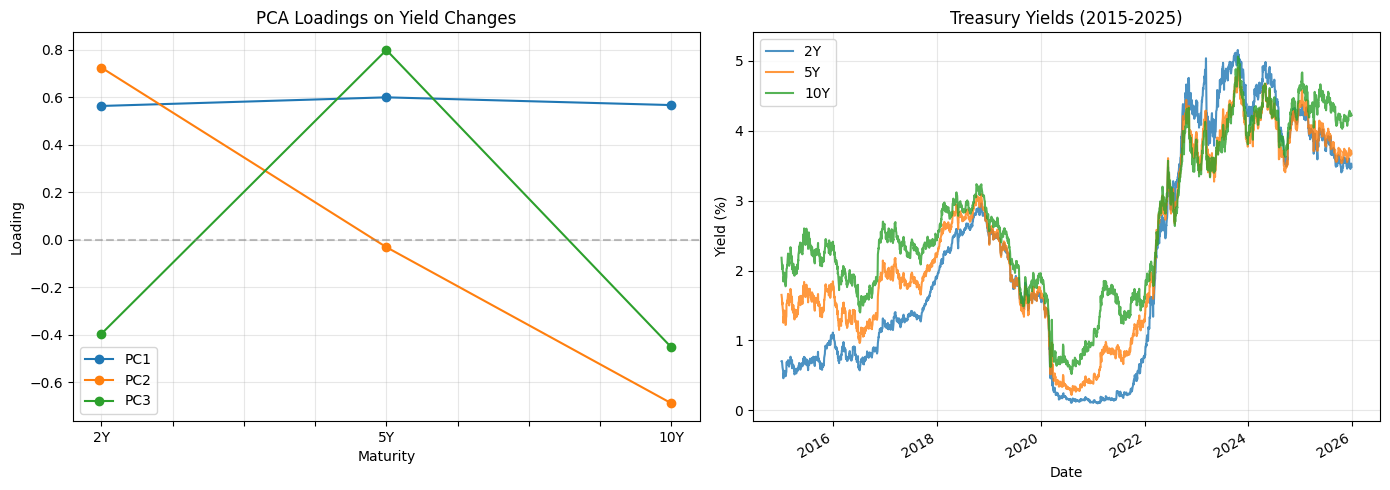

In [4]:
# Plot loadings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loadings
loadings.plot(ax=axes[0], marker='o')
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Maturity')
axes[0].set_ylabel('Loading')
axes[0].set_title('PCA Loadings on Yield Changes')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Yield levels over time
yields.plot(ax=axes[1], alpha=0.8)
axes[1].set_ylabel('Yield (%)')
axes[1].set_title('Treasury Yields (2015-2025)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

## 5. Questions

### Question 1: Factor Discovery

**Run PCA on yield changes and interpret the factors.**

a) Compute daily yield changes for 2Y, 5Y, and 10Y maturities. Standardize the changes before running PCA.

b) Report:
   - Variance explained by each of the first 3 components
   - Factor loadings (plot as a line chart across maturities)

c) Interpret each factor economically:
   - Which factor captures parallel shifts?
   - Which captures steepening/flattening?
   - Which captures curvature?

d) Test loading stability: Re-run PCA on the first half and second half of your sample separately. Do the loadings change materially? What does this imply for using fixed weights over time?

*Note: Discussion 2.1 runs PCA on yield levels. Here you run PCA on yield changes—the standard approach for risk management. Comment on why this distinction matters.*

### Question 2: Butterfly Construction

**Construct a 2s5s10s butterfly that is neutral to PC1 and PC2.**

a) Rescale the PC3 loadings so $w_{5Y} = -1$ (short the belly) and PC1 exposure = 0 = PC2 exposure.

b) Verify your construction: Compute the butterfly portfolio's exposure to PC1, PC2, and PC3. Confirm that PC1 and PC2 exposures are approximately zero.

c) Compute the butterfly spread time series:
   $$\text{Spread}_t = w_{2Y} \times y_{2Y,t} + w_{5Y} \times y_{5Y,t} + w_{10Y} \times y_{10Y,t}$$

d) Report summary statistics (mean, standard deviation, min, max) for the spread and plot the series. Does the spread appear to exhibit mean-reversion?

### Question 3: Signal Design and Backtest

**Design a mean-reversion trading strategy on the butterfly spread.**

a) Construct a z-score signal:
   - Choose a lookback window for the rolling mean and standard deviation (justify your choice—consider the tradeoff between responsiveness and stability)
   - Compute: $z_t = (\text{spread}_t - \mu_t) / \sigma_t$

b) Define trading rules:
   - Entry: When should you go long curvature? Short curvature?
   - Exit: When should you close the position?
   - Document your threshold choices (e.g., ±1σ, ±1.5σ, ±2σ)

c) Backtest the strategy daily:
   - $\text{P\&L}_t = \text{position}_{t-1} \times \Delta\text{spread}_t$
   - Report: cumulative P&L, Sharpe ratio, maximum drawdown, hit rate

d) Sensitivity analysis: How do results change with different entry thresholds? Present a table comparing at least three threshold choices.

### Question 4: Regime Analysis

**Analyze strategy performance across market regimes.**

a) Define at least three regimes based on market conditions. Suggested periods:
   - Pre-COVID (2015-2019): Normal monetary policy
   - COVID/QE (2020-2021): Zero rates, massive Fed intervention
   - Hiking cycle (2022-2023): Aggressive tightening
   - Recent (2024): Rate stabilization

b) For each regime, report:
   - Sharpe ratio
   - Butterfly spread volatility
   - Win rate

c) In which regime does the strategy perform best? Worst? Interpret:
   - Does higher volatility help or hurt a mean-reversion strategy?
   - Does trending curve behavior (e.g., during the hiking cycle) break mean-reversion?

d) Propose one modification to improve performance in the weakest regime. This could involve signal design, position sizing, or risk controls.

### Question 5: Implementation Gap

**Compare yield-space P&L to bond-space returns.**

This question confronts the gap between academic factor analysis and implementable trades.

a) **Design a roll schedule.** Using the bond panel (`treasury_panel_pca.xlsx`), you need to select actual bonds to proxy 2Y, 5Y, and 10Y maturities. Decide on:
   - **Roll frequency:** monthly or quarterly?
   - **Selection criteria:** closest TTM to target? Prefer on-the-run (low `age_days`)?
   
   Document your choices and rationale. There is no single correct answer—tradeoffs exist between tracking error, transaction costs, and liquidity.

b) **Construct the butterfly using actual bonds.** At each roll date:
   - Select the bond closest to each target maturity (2Y, 5Y, 10Y)
   - Apply your PCA-neutral weights, scaled by duration
   - Hold these bonds until the next roll date
   
   Compute daily bond returns between roll dates (price changes plus accrued interest changes).

c) **Compare yield-space vs bond-space P&L.** Compute the correlation and R² between:
   - Yield-space butterfly changes (from Question 3)
   - Bond-space portfolio returns
   
   Plot both series on the same chart.

d) **Analyze the sources of discrepancy:**

   - **Yield changes**: At each timestep, the indivudal bond's yield change will be different than the fixed maturity yield change. This is due to different maturities as well as factors idiosyncratic to the bond itself. How correlated are GSW yield changes with held bond yield changes? Show the relationship with a plot.
     
   - **First-order approxiation**: We can model bond returns from yields via first order approximation via duration. How correlated are our approximated returns to the actual bond returns? Show the relationship with a plot.

e) **Discuss:** Is the yield-space backtest a reliable guide to actual trading performance? What adjustments would you make for a production implementation?